In [1]:
import json
import gzip
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns

# Data Modeling

In [2]:
def readGzFile(filename):
    with gzip.open(filename, 'rb') as f:
        lines = f.readlines()
    df=[]
    for line in lines:
        df.append(json.loads(line))
    return df

brands_json = readGzFile('brands.json.gz')
receipts_json = readGzFile('receipts.json.gz')
users_json = readGzFile('users.json.gz')

## Brands

In [3]:
brands = pd.json_normalize(brands_json, max_level=2)

In [4]:
brands = brands.rename(columns={'_id.$oid':'brand_id',
                               'cpg.$id.$oid':'cpg_oid',
                               'cpg.$ref':'cpg_ref'})
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   barcode       1167 non-null   object
 1   category      1012 non-null   object
 2   categoryCode  517 non-null    object
 3   name          1167 non-null   object
 4   topBrand      555 non-null    object
 5   brand_id      1167 non-null   object
 6   cpg_oid       1167 non-null   object
 7   cpg_ref       1167 non-null   object
 8   brandCode     933 non-null    object
dtypes: object(9)
memory usage: 82.2+ KB


## Users

In [5]:
users = pd.json_normalize(users_json, max_level=1)

In [6]:
users = users.rename(columns={'_id.$oid':'user_id',
                               'createdDate.$date':'createdDate',
                               'lastLogin.$date':'lastLogin'})

In [7]:
def toDateTime(df, columnName):
    df[columnName] = pd.to_datetime(df[columnName]/1000, unit='s')

toDateTime(users, 'createdDate')
toDateTime(users, 'lastLogin')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   active        495 non-null    bool          
 1   role          495 non-null    object        
 2   signUpSource  447 non-null    object        
 3   state         439 non-null    object        
 4   user_id       495 non-null    object        
 5   createdDate   495 non-null    datetime64[ns]
 6   lastLogin     433 non-null    datetime64[ns]
dtypes: bool(1), datetime64[ns](2), object(4)
memory usage: 23.8+ KB


## Receipts & RewardsReceiptItem

In [8]:
receipts_all = pd.json_normalize(receipts_json)

In [9]:
receipts = receipts_all.drop(columns='rewardsReceiptItemList').rename(
    columns={
        '_id.$oid': 'receipt_id',
        'userId': 'user_id',
        'createDate.$date': 'createDate',
        'dateScanned.$date': 'dateScanned',
        'finishedDate.$date': 'finishedDate',
        'modifyDate.$date': 'modifyDate',
        'pointsAwardedDate.$date': 'pointsAwardedDate',
        'purchaseDate.$date': 'purchaseDate'
    })

In [10]:
toDateTime(receipts, 'createDate')
toDateTime(receipts, 'dateScanned')
toDateTime(receipts, 'finishedDate')
toDateTime(receipts, 'modifyDate')
toDateTime(receipts, 'pointsAwardedDate')
toDateTime(receipts, 'purchaseDate')

In [11]:
receipts.pointsEarned = receipts.pointsEarned.astype('float64')
receipts.purchasedItemCount = receipts.purchasedItemCount.astype('float64')
receipts.totalSpent = receipts.totalSpent.astype('float64')

receipts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bonusPointsEarned        544 non-null    float64       
 1   bonusPointsEarnedReason  544 non-null    object        
 2   pointsEarned             609 non-null    float64       
 3   purchasedItemCount       635 non-null    float64       
 4   rewardsReceiptStatus     1119 non-null   object        
 5   totalSpent               684 non-null    float64       
 6   user_id                  1119 non-null   object        
 7   receipt_id               1119 non-null   object        
 8   createDate               1119 non-null   datetime64[ns]
 9   dateScanned              1119 non-null   datetime64[ns]
 10  finishedDate             568 non-null    datetime64[ns]
 11  modifyDate               1119 non-null   datetime64[ns]
 12  pointsAwardedDate        537 non-n

In [12]:
for i in receipts_json:
    if 'rewardsReceiptItemList' not in i.keys():
        i.update({'rewardsReceiptItemList': [{'barcode': None}]})
        
# rewardsReceiptItem = pd.json_normalize(receipts_json['rewardsReceiptItemList'],errors='ignore',record_prefix='rewardsReceiptItemList')
rewardsReceiptItem = pd.json_normalize(receipts_json, 
                                       record_path='rewardsReceiptItemList',
                                       meta=[['_id','$oid']]
                                      ).rename(columns={'_id.$oid': 'receipt_id'})

In [13]:
rewardsReceiptItem.finalPrice = rewardsReceiptItem.finalPrice.astype('float64')
rewardsReceiptItem.itemPrice = rewardsReceiptItem.itemPrice.astype('float64')
rewardsReceiptItem.partnerItemId = rewardsReceiptItem.partnerItemId.astype('float64')
rewardsReceiptItem.userFlaggedBarcode = rewardsReceiptItem.userFlaggedBarcode.astype('float64')
rewardsReceiptItem.userFlaggedPrice = rewardsReceiptItem.userFlaggedPrice.astype('float64')
rewardsReceiptItem.discountedItemPrice = rewardsReceiptItem.discountedItemPrice.astype('float64')
rewardsReceiptItem.itemNumber = rewardsReceiptItem.itemNumber.astype('float64')
rewardsReceiptItem.pointsEarned = rewardsReceiptItem.pointsEarned.astype('float64')
rewardsReceiptItem.targetPrice = rewardsReceiptItem.targetPrice.astype('float64')
rewardsReceiptItem.originalFinalPrice = rewardsReceiptItem.originalFinalPrice.astype('float64')
rewardsReceiptItem.originalMetaBriteItemPrice = rewardsReceiptItem.originalMetaBriteItemPrice.astype('float64')
rewardsReceiptItem.priceAfterCoupon = rewardsReceiptItem.priceAfterCoupon.astype('float64')

rewardsReceiptItem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   barcode                             3090 non-null   object 
 1   description                         6560 non-null   object 
 2   finalPrice                          6767 non-null   float64
 3   itemPrice                           6767 non-null   float64
 4   needsFetchReview                    813 non-null    object 
 5   partnerItemId                       6941 non-null   float64
 6   preventTargetGapPoints              358 non-null    object 
 7   quantityPurchased                   6767 non-null   float64
 8   userFlaggedBarcode                  337 non-null    float64
 9   userFlaggedNewItem                  323 non-null    object 
 10  userFlaggedPrice                    299 non-null    float64
 11  userFlaggedQuantity                 299 non

# Questions

## What are the top 5 brands by receipts scanned for most recent month?

In [14]:
pysqldf = lambda q: sqldf(q, globals())

mostRecentM = '''
SELECT max(strftime('%Y-%m', dateScanned))  as ym
FROM receipts
'''
pysqldf(mostRecentM)

,ym
0,2021-03


The most recent month is March 2021, however there is no item in this month. \
For Feb 2021, there are only 6 records, and the top 3 brands are 'BRAND', 'MISSION', and 'VIVA'. \
For Jan 2021, the top 5 brands are 'HY-VEE', 'BEN AND JERRYS', 'PEPSI', 'KROGER' and 'KLEENEX'.

In [15]:
top5Brand_Feb = '''
SELECT 
    brandCode, 
    COUNT(brandCode) as cnt,
    strftime('%Y-%m', dateScanned) as ym
FROM receipts r LEFT JOIN rewardsReceiptItem i
ON r.receipt_id = i.receipt_id
WHERE ym = '2021-02'
GROUP BY brandCode
ORDER BY cnt DESC
LIMIT 5
'''

pysqldf(top5Brand_Feb)

,brandCode,cnt,ym
0,BRAND,3,2021-02
1,MISSION,2,2021-02
2,VIVA,1,2021-02
3,None,0,2021-02


In [16]:
top5Brand_Jan = '''
SELECT 
    brandCode, 
    COUNT(brandCode) as cnt,
    strftime('%Y-%m', dateScanned) as ym
FROM receipts r LEFT JOIN rewardsReceiptItem i
ON r.receipt_id = i.receipt_id
WHERE ym = '2021-01'
GROUP BY brandCode
ORDER BY cnt DESC
LIMIT 5
'''

pysqldf(top5Brand_Jan)

,brandCode,cnt,ym
0,HY-VEE,291,2021-01
1,BEN AND JERRYS,180,2021-01
2,PEPSI,93,2021-01
3,KROGER,89,2021-01
4,KLEENEX,88,2021-01


# Data Quality Check

## Duplicates Check

According to the dimension check, we found that there are duplicated records in 'users' dataset.

In [17]:
def get_dimension(Dataset,DatasetName):
    print("{} Dimensions: {} x {}"
          .format(DatasetName,
                  Dataset.shape[0], 
                  Dataset.shape[1]))
      
get_dimension(brands,'brands')
get_dimension(users,'users')
get_dimension(receipts,'receipts')  
get_dimension(rewardsReceiptItem,'rewardsReceiptItem')

brands Dimensions: 1167 x 9
users Dimensions: 495 x 7
receipts Dimensions: 1119 x 14
rewardsReceiptItem Dimensions: 7381 x 35


In [18]:
brands_dup = brands.drop_duplicates()
get_dimension(brands_dup,'brands_dup')

brands_dup Dimensions: 1167 x 9


In [19]:
users_dup = users.drop_duplicates()
get_dimension(users_dup,'users_dup')

users_dup Dimensions: 212 x 7


In [20]:
receipts_dup = receipts.drop_duplicates()
get_dimension(receipts_dup,'receipts_dup')

receipts_dup Dimensions: 1119 x 14


In [21]:
rewardsReceiptItem_dup = rewardsReceiptItem.drop_duplicates()
get_dimension(rewardsReceiptItem_dup,'rewardsReceiptItem_dup')

rewardsReceiptItem_dup Dimensions: 7381 x 35


## Missing Values Check

After getting the percentage of missing values in the datasets, we can see that there are lots of missing values in the datasets.

In [22]:
def get_perc_missing(df):
    perc_missing = df.isnull().sum()*100 / len(df)
    return perc_missing

In [23]:
get_perc_missing(brands)

barcode          0.000000
category        13.281919
categoryCode    55.698372
name             0.000000
topBrand        52.442159
brand_id         0.000000
cpg_oid          0.000000
cpg_ref          0.000000
brandCode       20.051414
dtype: float64

In [24]:
get_perc_missing(users)

active           0.000000
role             0.000000
signUpSource     9.696970
state           11.313131
user_id          0.000000
createdDate      0.000000
lastLogin       12.525253
dtype: float64

In [25]:
get_perc_missing(receipts)

bonusPointsEarned          51.385165
bonusPointsEarnedReason    51.385165
pointsEarned               45.576408
purchasedItemCount         43.252904
rewardsReceiptStatus        0.000000
totalSpent                 38.873995
user_id                     0.000000
receipt_id                  0.000000
createDate                  0.000000
dateScanned                 0.000000
finishedDate               49.240393
modifyDate                  0.000000
pointsAwardedDate          52.010724
purchaseDate               40.035746
dtype: float64

In [26]:
get_perc_missing(rewardsReceiptItem)

barcode                               58.135754
description                           11.123154
finalPrice                             8.318656
itemPrice                              8.318656
needsFetchReview                      88.985232
partnerItemId                          5.961252
preventTargetGapPoints                95.149709
quantityPurchased                      8.318656
userFlaggedBarcode                    95.434223
userFlaggedNewItem                    95.623899
userFlaggedPrice                      95.949058
userFlaggedQuantity                   95.949058
needsFetchReviewReason                97.032922
pointsNotAwardedReason                95.393578
pointsPayerId                         82.834304
rewardsGroup                          76.547893
rewardsProductPartnerId               69.258908
userFlaggedDescription                97.222599
originalMetaBriteBarcode              99.038071
originalMetaBriteDescription          99.864517
brandCode                             64

## Outliers Check

By drawing boxplots, we can see that there are obvious outliers in our dataset that need to be removed

In [27]:
def get_boxplot(df, col):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 3))
    sns.boxplot(data=df, x=col)
    ax.set_title('Boxplot of {}'.format(col), fontsize=16)
    plt.show()

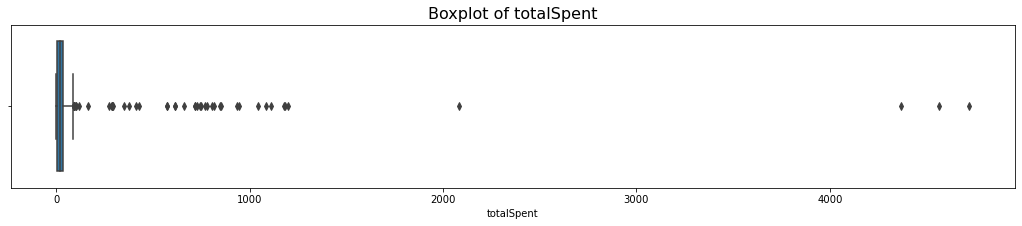

In [28]:
get_boxplot(receipts, 'totalSpent')

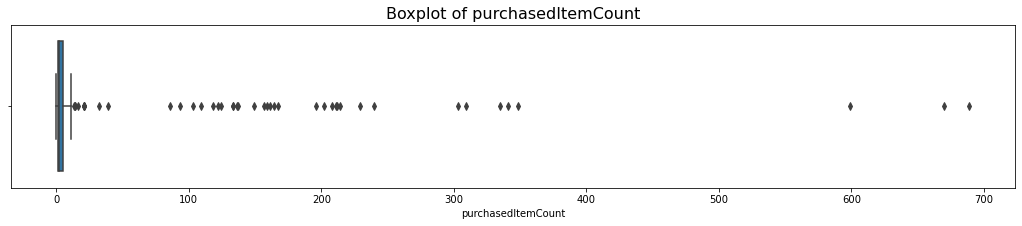

In [29]:
get_boxplot(receipts, 'purchasedItemCount')